In [27]:
import scipy.io     # used to load .mat data
import numpy as np
from plotting_utils import compare_cie_dist, compare_param_dist, plot_cie, plot_cie_raw_pred
import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import tqdm
import seaborn as sns

from models import MLP, TandemNet, cVAE, cGAN, INN
from utils import evaluate_simple_inverse, evaluate_tandem_accuracy, evaluate_vae_inverse, evaluate_gan_inverse, evaluate_inn_inverse
from configs import get_configs
from plotting_utils import compare_cie_dist, compare_param_dist, plot_cie, plot_cie_raw_pred
from datasets import get_dataloaders, SiliconColor

from sklearn.metrics import r2_score

#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'
train_loader, val_loader, test_loader = get_dataloaders('tandem_net')

### Define necessary function

In [62]:
def best_xyY(xyY_test, xyY_ideal):
    # find the best performance of xyY
    M = np.shape(xyY_test)[0]
    xyY_ideal = np.tile(xyY_ideal, (M,1))
    
    # use square root to measure the distance
    distance = np.sum(np.square(xyY_test -xyY_ideal),1)
    # use absolute value to measure the distance 
    #distance = np.sum(np.abs(xyY_test -xyY_ideal),1)
    return np.where(distance ==np.min(distance))

### Tandem


Tandem net Design RMSE loss 2.793
Tandem Design RMSE loss 184.924
Reconstruct RMSE loss 0.294
Reconstruct RMSE loss raw 0.037


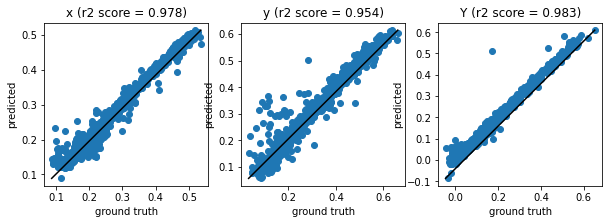

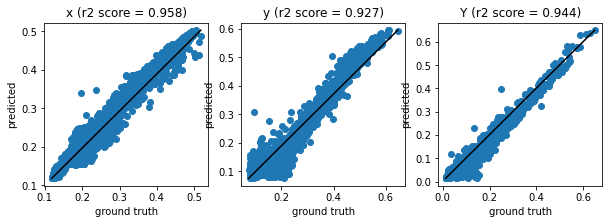

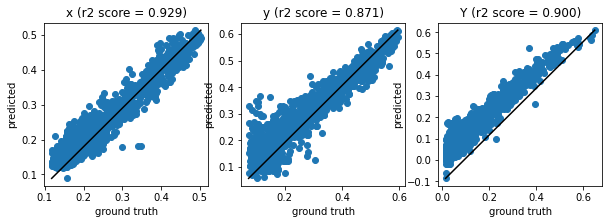

In [70]:
filepath ="data_predicted/xyY/xyY_param_tandem_pred.mat"
filepath2 = "data_predicted\param_tandem_pred.mat"

temp = scipy.io.loadmat(filepath)
CIE_x = np.array(list(temp.items())[3][1])
param_pred = np.array(list(temp.items())[4][1])
param_test = np.array(list(temp.items())[5][1])
xyY_pred = np.array(list(temp.items())[6][1])

temp = scipy.io.loadmat(filepath2)
deleted_row = np.array(list(temp.items())[6][1])

forward_model = MLP(4, 3).to(DEVICE)
inverse_model = MLP(3, 4).to(DEVICE)
tandem_model = TandemNet(forward_model, inverse_model)
tandem_model.load_state_dict(torch.load('./models/tandem_net_trained.pth')['model_state_dict'])
cie_raw, param_raw, cie_pred, param_pred = evaluate_tandem_accuracy(tandem_model, test_loader.dataset)

# Evaluation 1: comparing the CIE target against the estimated CIE using the forward model.
plot_cie_raw_pred(cie_raw, cie_pred)  

# Evaluation 2: comparing the CIE target against the actual CIE using RCWA 
plot_cie_raw_pred(CIE_x, xyY_pred)

# Evaluation 3: comparing the estimated CIE using the forward model against the actual CIE using RCWA
cie_pred = np.delete(cie_pred, deleted_row, 0)
plot_cie_raw_pred(xyY_pred, cie_pred)


### INN

Simple net Design RMSE loss 1.990
Simple net RMSE loss 133.691
Reconstruct RMSE loss 0.617
Reconstruct RMSE loss raw 0.077


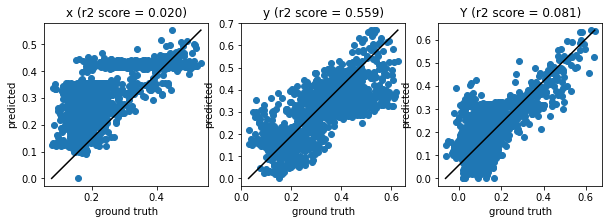

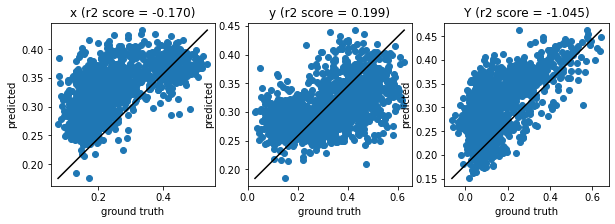

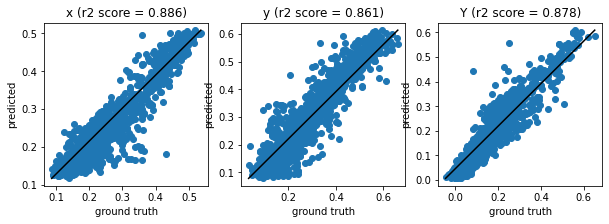

In [63]:
filepath ="data_predicted/xyY/xyY_param_inn_pred.mat"
filepath2 = "data_predicted\param_inn_pred.mat"

temp = scipy.io.loadmat(filepath)
CIE_x = np.array(list(temp.items())[3][1])
param_pred = np.array(list(temp.items())[4][1])
param_test = np.array(list(temp.items())[5][1])
xyY_pred = np.array(list(temp.items())[6][1])

temp = scipy.io.loadmat(filepath2)
deleted_row = np.array(list(temp.items())[6][1])

xyY_temp = np.reshape(xyY_pred, (-1, 3))
M = np.shape(xyY_pred)[0]
xyY_pred_avg = np.zeros([M, 3])
xyY_pred_best = np.zeros([M, 3])

for i in range(0,M):
    temp = xyY_temp[(5*i):(5*i+5),:]
    temp[np.isnan(temp)] = 0
    xyY_pred_avg[i,:] = np.average(temp, axis=0)
    xyY_pred_best[i,:] = temp[best_xyY(temp, CIE_x[i,:]),:]

plot_cie_raw_pred(CIE_x, xyY_pred_best)
plot_cie_raw_pred(CIE_x, xyY_pred_avg)

configs = get_configs('inn')
model = INN(configs['ndim_total'], configs['input_dim'], configs['output_dim'], dim_z = configs['latent_dim']).to(DEVICE)
model.load_state_dict(torch.load('./models/inn_trained.pth')['model_state_dict'], strict=False)

cie_raw, param_raw, cie_pred, param_pred = evaluate_inn_inverse(forward_model, model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)
